<h1 style="text-align: center;">Data Exploration</h1>

# Imports

In [1]:
# Standard libraries
import importlib
import os
import json
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# NLP / Transformers
from transformers import AutoTokenizer
from sentence_transformers import InputExample

# Utility
from pprint import pprint

# Own Modules
import data_exploration
importlib.reload(data_exploration)

<module 'data_exploration' from 'c:\\Users\\laraw\\GitHub\\AI-Lab\\data_exploration.py'>

# Explore csv (size, columns, labels)

In [2]:
# Path to the CSV file
csv_path = "data/semeval-2022_task8_train-data_batch.csv"

# Load the data
df = pd.read_csv(csv_path)

# Show structure
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Display first few rows
df.head()

Shape: (2939, 14)
Columns: ['url1_lang', 'url2_lang', 'pair_id', 'link1', 'link2', 'ia_link1', 'ia_link2', 'Geography', 'Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone']


url1_lang url2_lang                pair_id  \
0        en        en  1484084337_1484110209   
1        en        en  1484396422_1483924666   
2        en        en  1484698254_1483758694   
3        en        en  1576314516_1576455088   
4        en        en  1484036253_1483894099   

                                               link1  \
0  https://www.washingtonpost.com/local/virginia-...   
1  https://www.stlucianewsonline.com/guyana-three...   
2  https://www.teaparty.org/trump-brings-in-2020-...   
3  https://gadgets.ndtv.com/apps/news/zomato-uber...   
4  https://news.yahoo.com/india-approves-third-mo...   

                                               link2  \
0  https://www.washingtonpost.com/world/the_ameri...   
1  https://www.thestar.com/news/world/europe/2020...   
2  https://www.timesofisrael.com/trump-says-he-do...   
3  https://gadgets.ndtv.com/internet/news/indian-...   
4  https://www.channelnewsasia.com/news/asia/indi...   

                                            ia_link1  \
0  https://web.archive.org/web/www.washingtonpost...   
1  https://web.archive.org/web/www.stlucianewsonl...   
2  https://web.archive.org/web/www.teaparty.org/t...   
3  https://web.archive.org/web/gadgets.ndtv.com/a...   
4  https://web.archive.org/web/news.yahoo.com/ind...   

                                            ia_link2  Geography  Entities  \
0  https://web.archive.org/web/www.washingtonpost...        4.0  4.000000   
1  https://web.archive.org/web/www.thestar.com/ne...        4.0  4.000000   
2  https://web.archive.org/web/www.timesofisrael....        1.0  2.000000   
3  https://web.archive.org/web/gadgets.ndtv.com/i...        1.0  2.333333   
4  https://web.archive.org/web/www.channelnewsasi...        1.0  1.250000   

       Time  Narrative   Overall     Style      Tone  
0  1.000000   4.000000  4.000000  1.666667  2.000000  
1  1.000000   4.000000  3.666667  1.666667  1.333333  
2  1.000000   2.333333  2.333333  1.000000  1.333333  
3  2.666667   1.666667  2.000000  1.666667  1.666667  
4  1.000000   1.250000  1.250000  1.000000  1.000000

Overall is the label we want to learn

Continuous label -> Not Classification but Regression

similarity_bin
very different (0-1)         445
somewhat different (1-2)     544
somewhat similar(2-3)        561
very similar (3-4)          1389
Name: count, dtype: int64


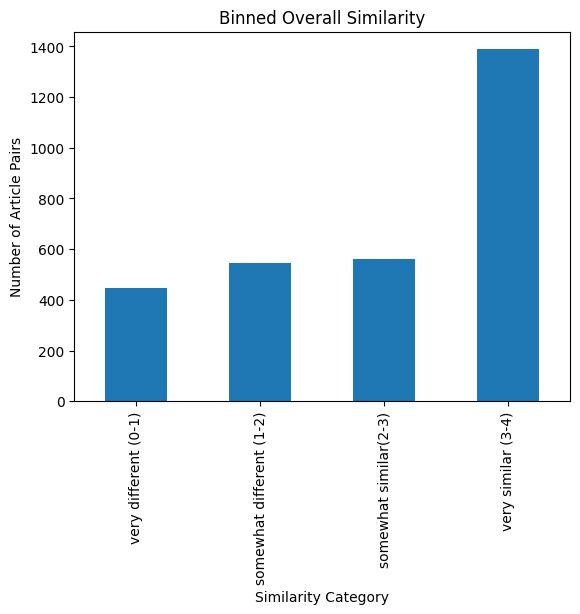

In [3]:
# Define bins and labels
bins = [0, 1, 2, 3, 4]
labels = ["very different (0-1)", "somewhat different (1-2)", "somewhat similar(2-3)", "very similar (3-4)"]
df["similarity_bin"] = pd.cut(df["Overall"], bins=bins, labels=labels, include_lowest=True)

# Show distribution
print(df["similarity_bin"].value_counts().sort_index())

# Bar plot distribution
import matplotlib.pyplot as plt

df["similarity_bin"].value_counts().sort_index().plot(kind="bar")
plt.title("Binned Overall Similarity")
plt.ylabel("Number of Article Pairs")
plt.xlabel("Similarity Category")
plt.show()

# Explore json

In [4]:
# Explore one pair of articles to understand csv and json structure

# Get the first row
example_row = df.iloc[0]
pair_id = str(example_row["pair_id"])

# Extract article IDs
article_ids = pair_id.split("_")
id1, id2 = article_ids[0], article_ids[1]

# Load both articles
article1 = data_exploration.load_article_json(id1)
article2 = data_exploration.load_article_json(id2)

# Combine all relevant info
example_pair = {
    "pair_id": pair_id,
    "csv_labels": example_row.to_dict(),
    "article_1": {
        "id": id1,
        "title": article1.get("title", "") if article1 else "",
        "url": article1.get("url", "") if article1 else "",
        "text_snippet": article1.get("text", "")[:500] if article1 else ""
    },
    "article_2": {
        "id": id2,
        "title": article2.get("title", "") if article2 else "",
        "url": article2.get("url", "") if article2 else "",
        "text_snippet": article2.get("text", "")[:500] if article2 else ""
    }
}

from pprint import pprint
pprint(example_pair)

{'article_1': {'id': '1484084337',
               'text_snippet': 'MARTINSBURG, W.Va. — A suspected drunken '
                               'driver was arrested in a New Year’s Day '
                               'highway crash that killed another motorist in '
                               'West Virginia, police said.\n'
                               '\n'
                               'The accident occurred early Wednesday along '
                               'southbound Interstate 81 in Berkeley County, '
                               'The Journal reported.\n'
                               '\n'
                               'Cody Wade Braithwaite, 32, of Winchester, '
                               'Virginia, was charged with DUI with death, '
                               'fleeing DUI, and being a prohibited person in '
                               'possession of a firearm and a fugitive from '
                               'justice, Berkeley County Sheriff Curtis Kell

# Combine csv and json to dataset

In [32]:
# Process csv and json for all data (limited to first x for performance)

dataset_df = data_exploration.build_text_pair_dataset(df, base_path="data")  # optional limit

dataset_df.to_csv("data/text_pair_dataset.csv", index=False)

display(dataset_df.head())

pair_id                                             title1  \
0  1484084337_1484110209  Virginia man arrested in fatal DUI crash in We...   
1  1484396422_1483924666  Guyana: Three injured after car crashes into u...   
2  1484698254_1483758694  Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...   
3  1576314516_1576455088  Zomato Buys Uber's Food Delivery Business in I...   
4  1484036253_1483894099  India approves third moon mission, months afte...   

                                               text1  \
0  MARTINSBURG, W.Va. — A suspected drunken drive...   
1  Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...   
2  (Breitbart) – President Donald Trump welcomed ...   
3  Uber has sold its online food-ordering busines...   
4  BENGALURU (Reuters) - India has approved its t...   

                                              title2  \
0  Haiti’s leader marks independence day amid sec...   
1  Fire kills more than 30 animals at zoo in west...   
2  Trump says he does not expect war with Iran, ‘...   
3  Indian Online Food Delivery Market to Hit $8 B...   
4             India targets new moon mission in 2020   

                                               text2     label  
0  PORT-AU-PRINCE, Haiti — Haitian President Jove...  4.000000  
1  BERLIN - A fire at a zoo in western Germany in...  3.666667  
2  PALM BEACH, United States — US President Donal...  2.333333  
3  Rapid digitisation and growth in both online b...  2.000000  
4  BANGALORE: India plans to make a fresh attempt...  1.250000

# Length of article texts

## Comparison Article 1 vs Article 2

In [22]:
df_texts = dataset_df.copy()

df_texts["len_text1"] = df_texts["text1"].str.len()
df_texts["len_text2"] = df_texts["text2"].str.len()

print("Text 1 Länge:")
print(df_texts["len_text1"].describe())

print("\nText 2 Länge:")
print(df_texts["len_text2"].describe())


Text 1 Länge:
count     2736.000000
mean      2922.824927
std       3570.000401
min          0.000000
25%       1142.750000
50%       2039.000000
75%       3577.500000
max      75830.000000
Name: len_text1, dtype: float64

Text 2 Länge:
count     2736.000000
mean      2269.072368
std       2408.553476
min          0.000000
25%        894.000000
50%       1602.000000
75%       2716.000000
max      31247.000000
Name: len_text2, dtype: float64


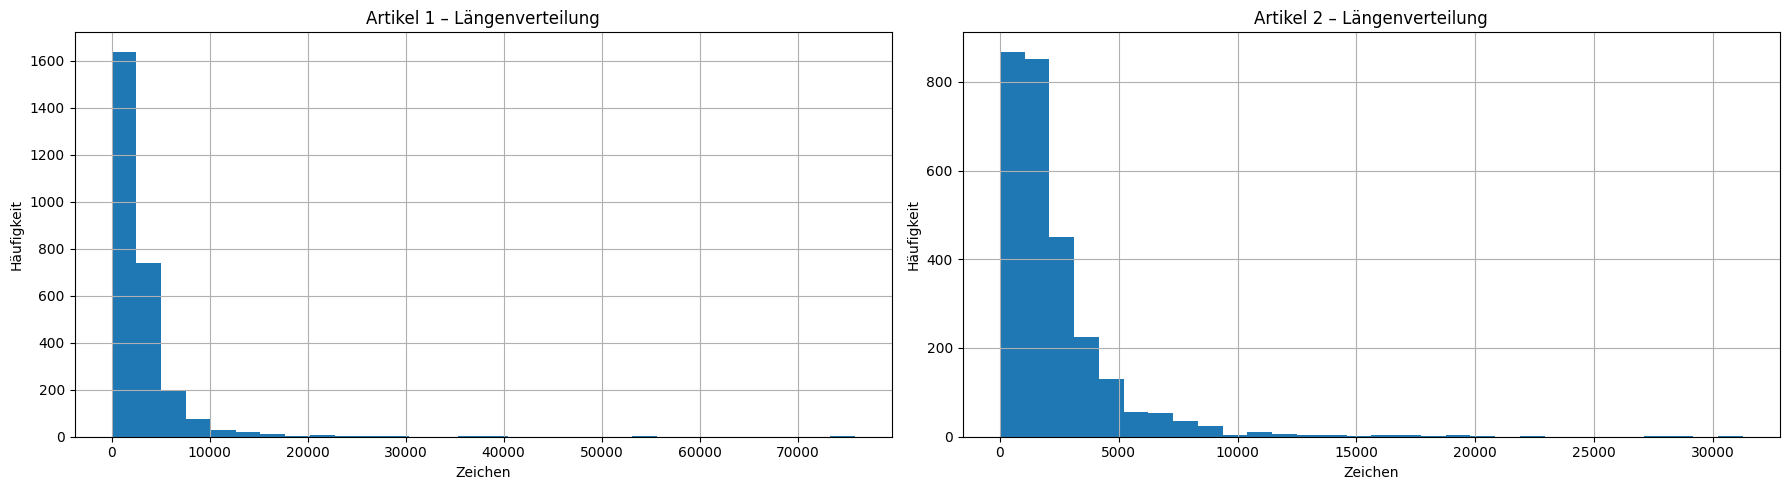

In [23]:

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Artikel 1
df_texts["len_text1"].hist(bins=30, ax=axes[0])
axes[0].set_title("Artikel 1 – Längenverteilung")
axes[0].set_xlabel("Zeichen")
axes[0].set_ylabel("Häufigkeit")

# Artikel 2
df_texts["len_text2"].hist(bins=30, ax=axes[1])
axes[1].set_title("Artikel 2 – Längenverteilung")
axes[1].set_xlabel("Zeichen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

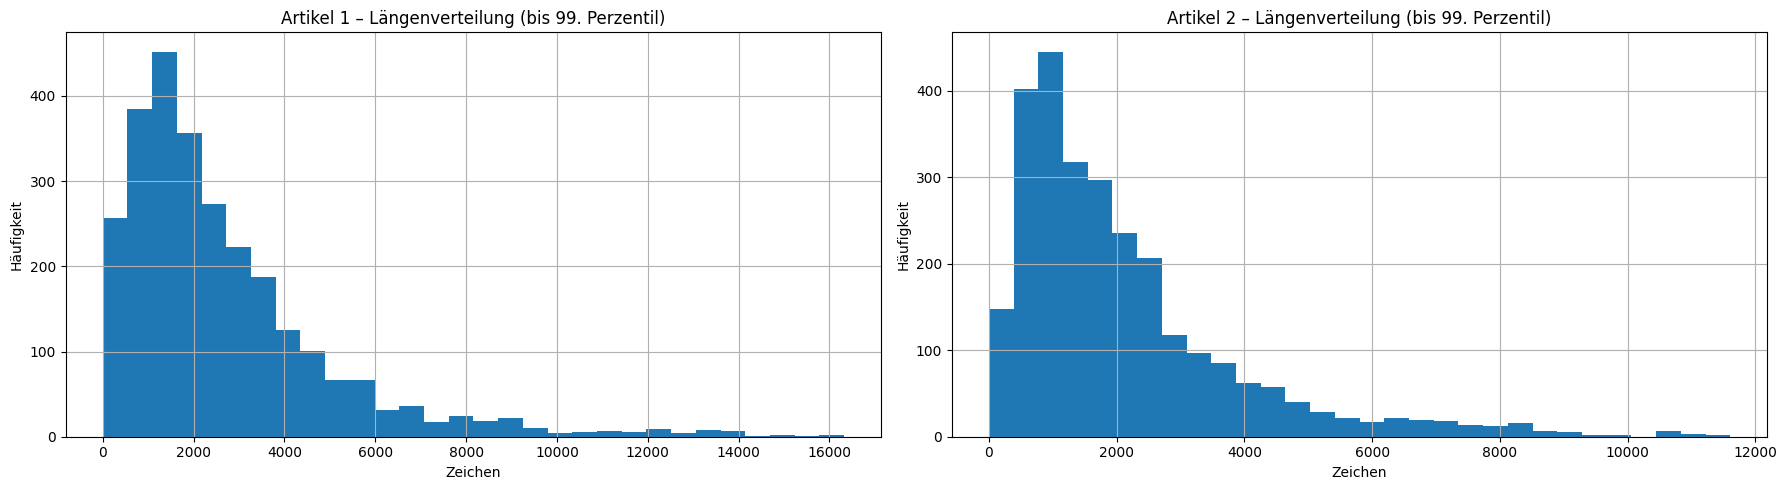

In [24]:

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Optional: 99. Perzentil als Cutoff für bessere Skalierung
max_len_1 = df_texts["len_text1"].quantile(0.99)
max_len_2 = df_texts["len_text2"].quantile(0.99)

# Artikel 1
df_texts[df_texts["len_text1"] < max_len_1]["len_text1"].hist(bins=30, ax=axes[0])
axes[0].set_title("Artikel 1 – Längenverteilung (bis 99. Perzentil)")
axes[0].set_xlabel("Zeichen")
axes[0].set_ylabel("Häufigkeit")

# Artikel 2
df_texts[df_texts["len_text2"] < max_len_2]["len_text2"].hist(bins=30, ax=axes[1])
axes[1].set_title("Artikel 2 – Längenverteilung (bis 99. Perzentil)")
axes[1].set_xlabel("Zeichen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

C:\Users\laraw\AppData\Local\Temp\ipykernel_15800\835337493.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_texts["len_text1"], df_texts["len_text2"]],


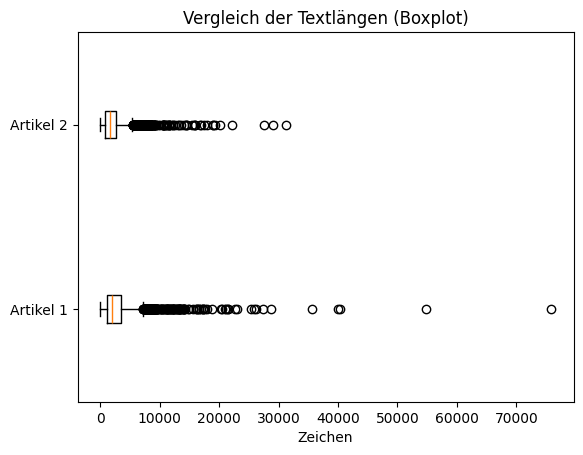

In [25]:
plt.boxplot([df_texts["len_text1"], df_texts["len_text2"]],
            vert=False,
            labels=["Artikel 1", "Artikel 2"])
plt.title("Vergleich der Textlängen (Boxplot)")
plt.xlabel("Zeichen")
plt.show()

## All Texts

Längenstatistik aller Texte:
count     5472.000000
mean      2595.948648
std       3062.382903
min          0.000000
25%        987.000000
50%       1807.000000
75%       3181.000000
max      75830.000000
dtype: float64


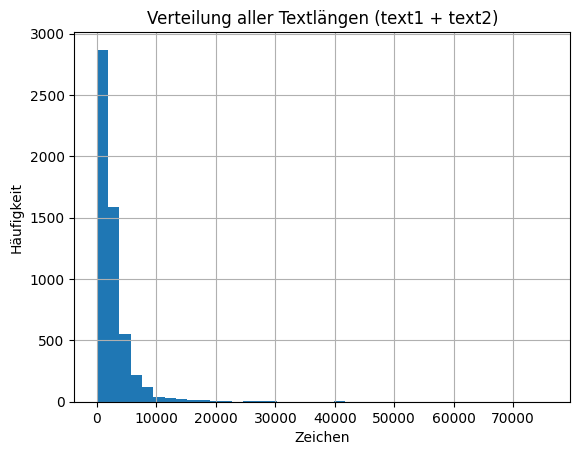

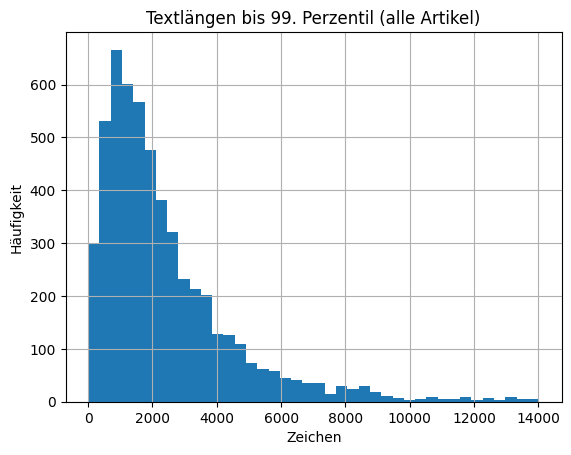

In [17]:
all_texts = pd.concat([df_texts["text1"], df_texts["text2"]], ignore_index=True)
text_lengths = all_texts.str.len()

print("Längenstatistik aller Texte:")
print(text_lengths.describe())

text_lengths.hist(bins=40)
plt.title("Verteilung aller Textlängen (text1 + text2)")
plt.xlabel("Zeichen")
plt.ylabel("Häufigkeit")
plt.show()

cutoff = text_lengths.quantile(0.99)
text_lengths[text_lengths < cutoff].hist(bins=40)
plt.title("Textlängen bis 99. Perzentil (alle Artikel)")
plt.xlabel("Zeichen")
plt.ylabel("Häufigkeit")
plt.show()